# Generate Approximate Hessians
Like the previous notebook, fit an approximate model and use that to compute the Hessian. Instead of treating the Hessian parameters as separate, we try here to fit a forcefield using the data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.mbtr import MBTREnergyModel, MBTRCalculator
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from dscribe.descriptors import MBTR
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings

Configuration

In [2]:
molecule_name = 'caffeine'
method = 'hf'
basis = 'def2-svpd'
step_size: float = 0.01 # Perturbation amount, used as maximum L2 norm

Derived

In [3]:
run_name = f'{molecule_name}_{method}_{basis}'
out_dir = Path('data') / 'approx'
db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [4]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 2701 structures


Read in the exact Hessian

In [5]:
with open(f'data/exact/{run_name}-ase.json') as fp:
    exact_vibs = VibrationsData.read(fp)

In [6]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()

## Fit a Hessian with All Data
Fit a model which explains the energy data by fitting a Hessian matrix using compressed sensing (i.e., Lasso).

Make the MBTR calculator using half the available data

In [7]:
%%time
mbtr = MBTRCalculator(
    model=GridSearchCV(
        KernelRidge(kernel='rbf', alpha=1e-6), {
            'alpha': np.logspace(-10, -7, 8),
            'gamma': np.logspace(-5, 5, 32)
    }),
    descriptor=MBTR(
        species=["H", "C", "N", "O"],
        geometry={"function": "distance"},
        grid={"min": 0, "max": 6, "n": 64, "sigma": 0.05},
        weighting={"function": "exp", "scale": 0.1, "threshold": 1e-3},
        periodic=False,
    )
)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mbtr.train(data[:len(data) // 2])

CPU times: user 6min 33s, sys: 22.4 s, total: 6min 56s
Wall time: 35.2 s


Plot the model performance

In [8]:
pred_energy= [mbtr.get_potential_energy(x) * 1000 for x in data[len(data) // 2:]]
true_energy = [x.get_potential_energy() * 1000 for x in data[len(data) // 2:]]

Text(0, 0.5, '$E-E_0$, True (meV)')

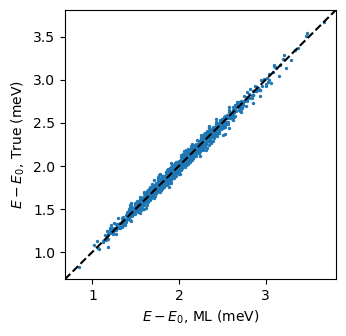

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

base_energy = data[0].get_potential_energy() * 1000  # in meV
ax.scatter(np.subtract(pred_energy, base_energy), np.subtract(true_energy, base_energy), s=2)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$E-E_0$, ML (meV)')
ax.set_ylabel('$E-E_0$, True (meV)')

Build the ASE-compatible calculator

In [10]:
model = MBTREnergyModel(reference=data[0], calc=mbtr)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hess_model = model.train(data)

In [11]:
hess_model.parameters['model'].best_params_

{'alpha': 1e-10, 'gamma': 9.284145445194744e-05}

Compare the forces estimated at a zero displacement to the true value

In [12]:
actual_forces = data[0].get_forces()

In [13]:
pred_forces = hess_model.get_forces(data[0])

In [14]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 9.25e-03 eV/Angstrom


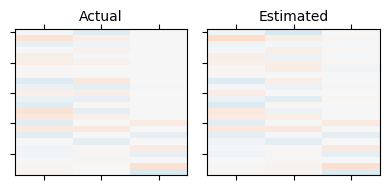

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [16]:
%%time
approx_hessian = model.mean_hessian(hess_model)

CPU times: user 40.6 s, sys: 15.1 ms, total: 40.6 s
Wall time: 40.6 s


Compare to exact answer

In [17]:
exact_hess[:3, :3]

array([[1.96495560e+01, 2.28518485e+01, 1.08009177e-03],
       [2.28518485e+01, 8.36964299e+01, 3.94902961e-03],
       [1.08009177e-03, 3.94902961e-03, 4.15881408e+00]])

In [18]:
approx_hessian[:3, :3]

array([[1.99647797e+01, 2.29521229e+01, 6.85504347e-03],
       [2.29521229e+01, 8.39212309e+01, 1.31434717e-02],
       [6.85504347e-03, 1.31434717e-02, 4.35586953e+00]])

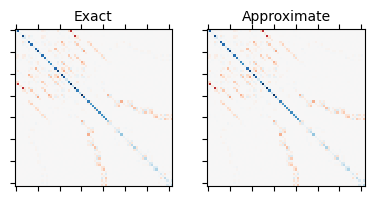

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [20]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [21]:
approx_vibs.get_zero_point_energy()

5.41561627027977

In [22]:
exact_zpe

5.5067174465850215

The two differ, but I'm not sure how important the difference is.

Save it to disk

In [23]:
with open(f'data/approx/{run_name}_d={step_size:.2e}_mbtr.json', 'w') as fp:
    approx_vibs.write(fp)

## Plot as a Function of Data
See what happens as we add more data to the training

In [24]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 184, 364, 544, 723, ...


In [25]:
zpes = []
for count in tqdm(steps):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hess_model = model.train(data[:count])
    
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    zpes.append(approx_vibs.get_zero_point_energy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [19:55<00:00, 74.72s/it]


Plot it

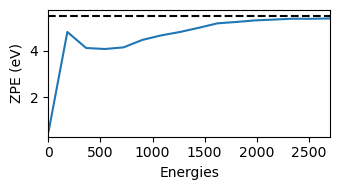

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps, zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()

We consistently underestimate the ZPE. Is it because we have too few oscillators?